https://sgpp.sparsegrids.org/docs/example_refinement_py.html   
https://sgpp.github.io/SGpp/example_combigrid_py.html

In [36]:
#allows any changes on external files to be loaded on code run.
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


debug tuple <class 'numpy.ndarray'>
debug tuple <class 'numpy.ndarray'>


/home/djdaniel/GENE_UQ/SGPP_testing/../GENE_ML/gene_ml/test_functions/max_of_many_gaussians.py:119: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


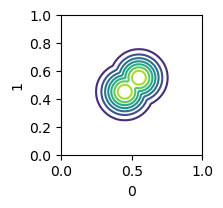

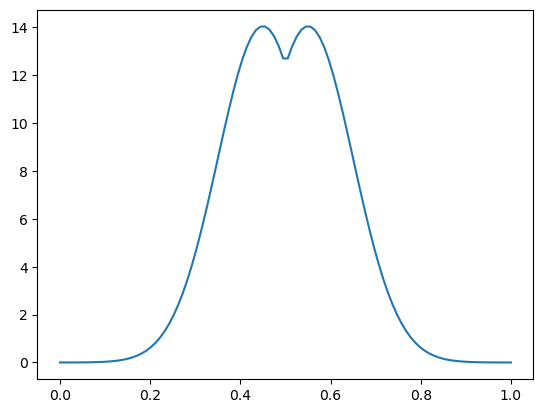

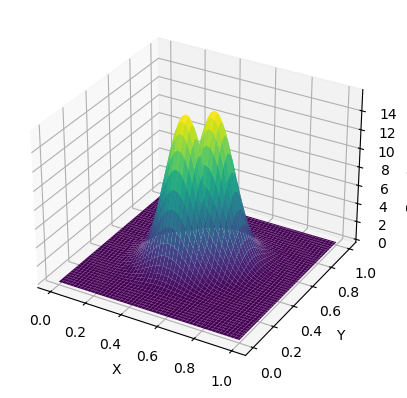

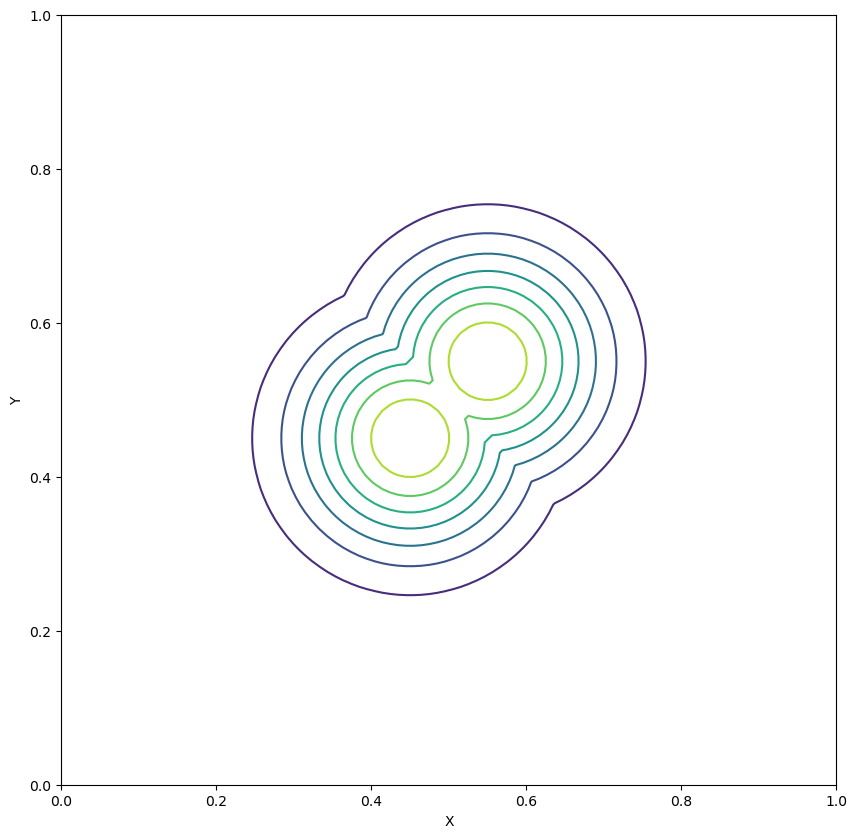

In [37]:
from GENE_ML.gene_ml.test_functions.max_of_many_gaussians import MaxOfManyGaussians
import numpy as np

num_dim = 2
bounds = [(0,1) for i in range(num_dim)]
num_gaussians = 2
std=0.1
mmg = MaxOfManyGaussians(num_dim, bounds)#num_dim, num_gaussians, bounds, mean_bounds, std_bounds, seed=10)

mmg.specify_gaussians(means=np.array([[0.45,0.45], [0.55,0.55]]), stds = np.array([[std,std],[std,std]]))
# mmg.plot_2d_gaussians(extra=0, grid_size=200, plot_bounds=[(0,1),(0,1)], style='contour')
# mmg.plot_2D_of_many(which2=(0,1), style='contour')
mmg.plot_matrix_contour()
if num_dim == 2: mmg.plot_2d_gaussians()

DO PLOT True
Value of test function at [0.12 0.34]: 0.820974
Value of combined sparse grid interpolant at [0.12 0.34]: 0.774666
TYPE YY <class 'pysgpp.pysgpp_swig.DataVector'>
Level of selected full grid with index 3: [1 3]
Value of full grid interpolant at [0.12 0.34]: -0.0557937
TYPE YY <class 'pysgpp.pysgpp_swig.DataVector'>


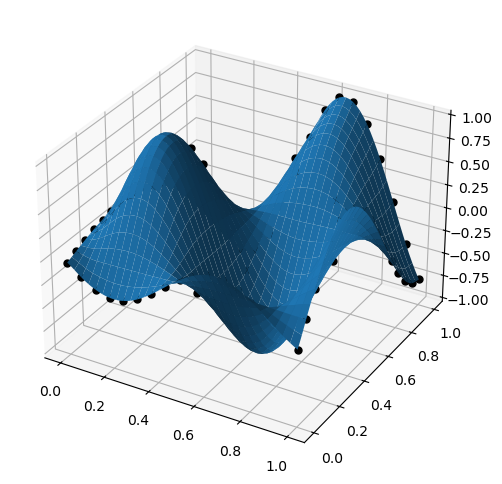

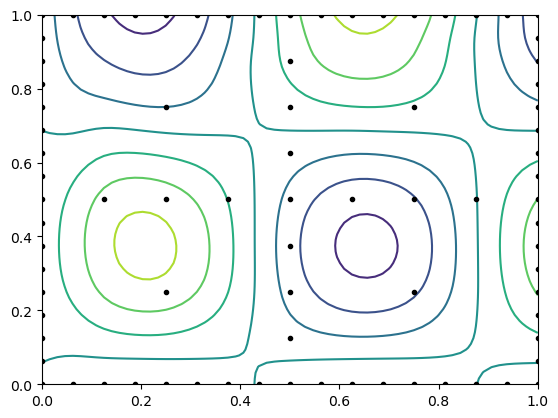

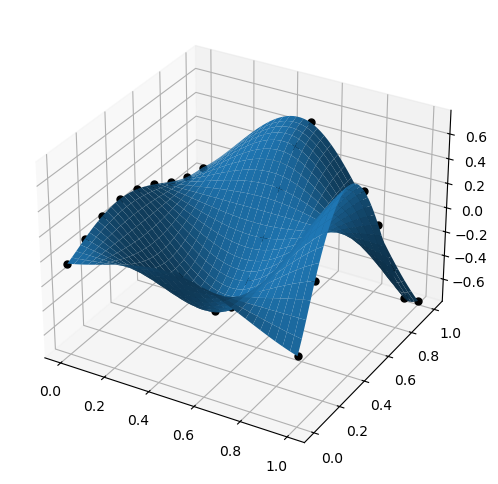

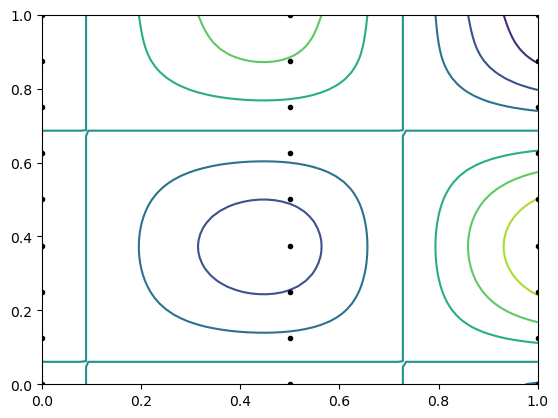

In [38]:
# Combigrid

import pysgpp
import numpy as np
import sys
 
# skip plotting if Matplotlib cannot be imported (e.g., not installed or no GUI available)
try:
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  doPlot = True
except ImportError:
  doPlot = False
  
print('DO PLOT', doPlot)
  
def plotFunction(opEval, surpluses, X):
  if not doPlot: return
 
  # generate a meshgrid for plotting
  xx0 = np.linspace(0, 1, 65)
  xx1 = np.linspace(0, 1, 65)
  XX0, XX1 = np.meshgrid(xx0, xx1)
  XX = pysgpp.DataMatrix(np.column_stack([XX0.flatten(), XX1.flatten()]))
 
  # evaluate interpolant at meshgrid
  YY = pysgpp.DataVector(0)
  opEval.multiEval(surpluses, XX, YY)
 
  # convert resulting sgpp::base::DataVector to NumPy array
  print('TYPE YY', type(YY))
  YY = np.reshape(np.array([YY[k] for k in range(YY.getSize())]), XX0.shape)
 
  # actual plotting
  fig = plt.figure(figsize=(6, 6))
  ax = fig.add_subplot(projection="3d")
  ax.plot_surface(XX0, XX1, YY)
  ax.plot(X[:,0], X[:,1], "k.", zs=f(X[:,0], X[:,1]), ms=10)
  
  fig2 = plt.figure()
  ax2 = fig2.add_subplot()
  ax2.contour(XX0, XX1, YY)
  ax2.plot(X[:,0], X[:,1], "k.")
  
# dimensionality
dim = 2
# regular level
n = 4
# B-spline degree
p = 3
# whether there are points on the boundary
hasBoundary = True
# test function
f = lambda XX0, XX1: np.sin(7*XX0-3)*np.cos(5*XX1-5)

# disable log output
pysgpp.Printer.getInstance().setVerbosity(-1)
basis1d = pysgpp.SBsplineBase(p)
basis = pysgpp.HeterogeneousBasis(dim, basis1d)

combiGrid = pysgpp.CombinationGrid.fromRegularSparse(dim, n, basis, hasBoundary)

gridStorage = pysgpp.HashGridStorage(dim)
combiGrid.combinePoints(gridStorage)
 
# convert grid storage to array with coordinates of grid points
X = np.array([[gridStorage.getPoint(k).getStandardCoordinate(d) for d in range(dim)]
              for k in range(gridStorage.getSize())])
 
# evaluate test function at grid points
fX = pysgpp.DataVector(f(X[:,0], X[:,1]))

values = pysgpp.DataVectorVector()
combiGrid.distributeValuesToFullGrids(gridStorage, fX, values)

# copy the values (surpluses will be modified in-place)
surpluses = pysgpp.DataVectorVector(values)
 
# create pole operation
opPole = pysgpp.OperationPoleVector()
pysgpp.OperationPoleHierarchisationGeneral.fromHeterogenerousBasis(basis, opPole)
 
# create operation for unidirectional principle and hierarchize in-place
opHier = pysgpp.OperationUPCombinationGrid(combiGrid, opPole)
opHier.apply(surpluses)

# test point at which to evaluate
x = [0.12, 0.34]
xDv = pysgpp.DataVector(x)
print("Value of test function at {}: {:.6g}".format(np.array(x), f(*x)))
# create operation for evaluating and evaluate
opEval = pysgpp.OperationEvalCombinationGrid(combiGrid)
y = opEval.eval(surpluses, xDv)
print("Value of combined sparse grid interpolant at {}: {:.6g}".format(np.array(x), y))
# plot
plotFunction(opEval, surpluses, X)

# select the second full grid of the combination grid (arbitrary choice)
fullGridIndex = 3
fullGrid = combiGrid.getFullGrids()[fullGridIndex]
l = fullGrid.getLevel()
print("Level of selected full grid with index {}: {}".format(fullGridIndex, np.array(l)))
 
# create operation for evaluating and evaluate
opEval = pysgpp.OperationEvalFullGrid(fullGrid)
y = opEval.eval(surpluses[fullGridIndex], xDv)
print("Value of full grid interpolant at {}: {:.6g}".format(np.array(x), y))

# compute grid points of full grid
X = pysgpp.DataMatrix(0, 0)
pysgpp.IndexVectorRange.getPoints(fullGrid, X)
 
# convert resulting sgpp::base::DataMatrix to NumPy array
X = np.array([[X.get(k, j) for j in range(X.getNcols())] for k in range(X.getNrows())])
 
# plot
plotFunction(opEval, surpluses[fullGridIndex], X)
 
if doPlot: plt.show()
else: print("Skipping plots due to failed import of Matplotlib.")

In [35]:
# X = pysgpp.DataMatrix(0, 0)
# pysgpp.IndexVectorRange.getPoints(fullGrid, X)

# type(X)
print(surpluses.size())
print(dir(surpluses[0]))
print(surpluses[0].getSize())
i, j = 0, 0
print(type(surpluses[i]))
print(surpluses[i][j])

9
['RMSNorm', '_DataVector__array', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__swig_container', '__swig_destroy__', '__weakref__', 'abs', 'add', 'append', 'array', 'assign', 'axpy', 'componentwise_div', 'componentwise_mult', 'copyFrom', 'dotProduct', 'fromFile', 'get', 'getNumberNonZero', 'getSize', 'l2Norm', 'max', 'maxNorm', 'min', 'minmax', 'mult', 'normalize', 'partitionClasses', 'resize', 'resizeZero', 'restructure', 'set', 'setAll', 'sqr', 'sqrt', 'sub', 'sum', 'this', 'thisown', 'toFile', 'toString']
34
<class 'pysgpp.pysgpp_swig.DataVector'>
0.024640227652499958


In [19]:
# convert resulting sgpp::base::DataMatrix to NumPy array
X = pysgpp.DataMatrix(0, 0)
pysgpp.IndexVectorRange.getPoints(fullGrid, X)
def convert_sgpp_matrix_to_numpy(sgpp_matrix):
    sgpp_matrix = np.array([[sgpp_matrix.get(k, j) for j in range(sgpp_matrix.getNcols())] for k in range(sgpp_matrix.getNrows())])
    return sgpp_matrix
def convert_sgpp_vector_to_numpy(sgpp_vector):
    sgpp_vector = np.array([sgpp_vector[i] for i in range(sgpp_vector.size())])
convert_sgpp_matrix_to_numpy(X)

convert_sgpp_vector_to_numpy(surpluses)



: 

In [16]:
dir(surpluses)

['__bool__',
 '__class__',
 '__delattr__',
 '__delitem__',
 '__delslice__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getslice__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__setslice__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__swig_destroy__',
 '__weakref__',
 'append',
 'assign',
 'back',
 'begin',
 'capacity',
 'clear',
 'empty',
 'end',
 'erase',
 'front',
 'get_allocator',
 'insert',
 'iterator',
 'pop',
 'pop_back',
 'push_back',
 'rbegin',
 'rend',
 'reserve',
 'resize',
 'size',
 'swap',
 'this',
 'thisown']